In [1]:
# Load IPython extension to reload modules
%load_ext autoreload
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
# from torch.optim import lr_scheduler

/mnt/ey/conda_envs/py3.6.3_env1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/mnt/ey/conda_envs/py3.6.3_env1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
sys.path.append("../src/")
from dataset import DummyDataset
from network import NormEmbeddingNet, NormClampEmbeddingNet, extract_embedding
from loss import OnlineTripletLoss, OnlineNonLinearTripletLoss
from metric import AverageNonZeroTripletsMetric
from trainer import fit
from sampler import BalancedBatchSampler, SemiHardNegativeTripletSelector, MarginallyHardNegativeTripletSelector
from display import plot_image, plot_2d_circle, plot_2d_embedding

## Load Dummy Dataset

In [4]:
ds_dummy = DummyDataset()


Loading Dummy Dataset ...
Class distribution:
0    1000
1     136
Name: class, dtype: int64
Number of signals: 9
Number of signal steps: 29
Number of records: 1136


### Examples of Class 0

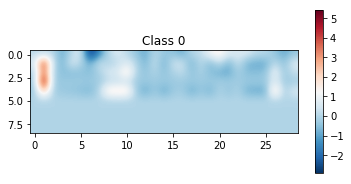

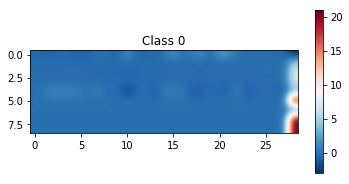

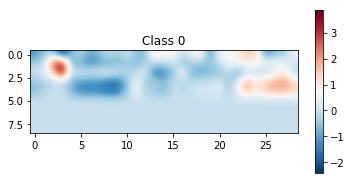

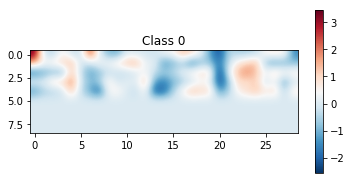

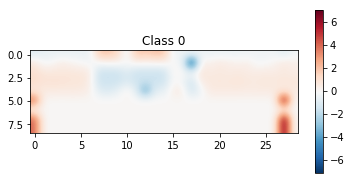

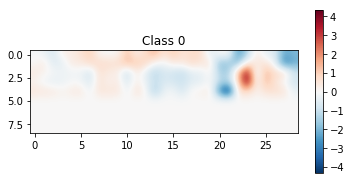

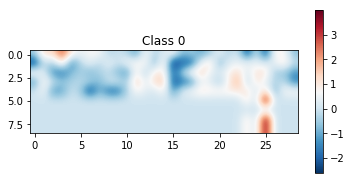

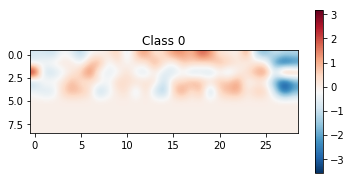

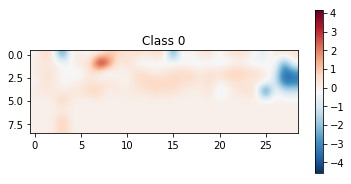

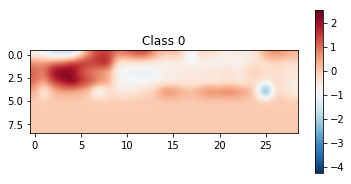

In [5]:
for i in range(500, 510):
    data = ds_dummy.__getitem__(i)[0]
    target = ds_dummy.__getitem__(i)[1]
    plot_image(data, target)


### Examples of Class 1

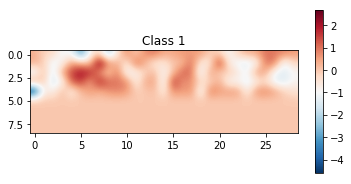

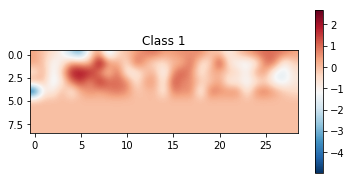

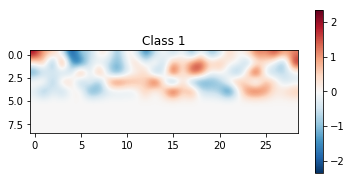

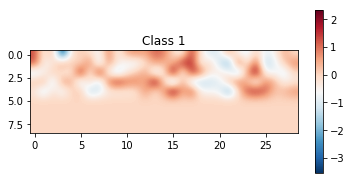

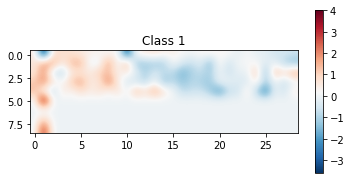

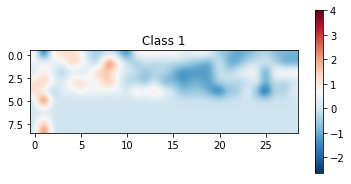

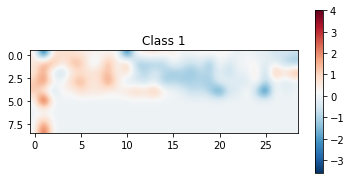

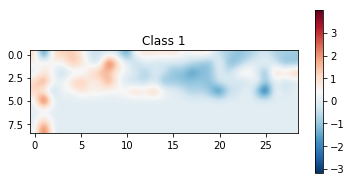

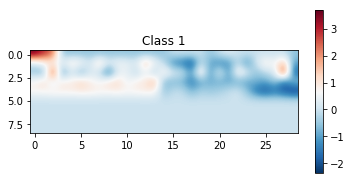

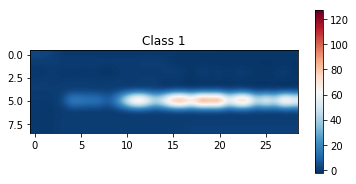

In [6]:
for i in range(0, 10):
    data = ds_dummy.__getitem__(i)[0]
    target = ds_dummy.__getitem__(i)[1]
    plot_image(data, target)


In [7]:
dict_args = dict()
dict_args["batch_size"] = 256
dict_args["no_cuda"] = False
dict_args["optimizer"] = "Adam"
dict_args["lr"] = 1e-2
dict_args["epochs"] = 50
dict_args["margin"] = 0.5
dict_args["log_interval"] = None
dict_args["seed"] = 1

use_cuda = not dict_args["no_cuda"] and torch.cuda.is_available()

torch.manual_seed(dict_args["seed"])

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

print("use_cuda :", use_cuda)
print("device :", device)

use_cuda : False
device : cpu


In [8]:
train_loader = DataLoader(ds_dummy, 
                         batch_size=dict_args["batch_size"], 
                         shuffle=False, **kwargs)

for batch_idx, (data, target) in enumerate(train_loader):
    print(data.shape, target.shape)
    break

train_batch_sampler = BalancedBatchSampler(ds_dummy, n_classes=2, n_samples=256)
online_train_loader = DataLoader(ds_dummy, batch_sampler=train_batch_sampler, **kwargs)

for batch_idx, (data, target) in enumerate(online_train_loader):
    print(data.shape, target.shape)
    break

torch.Size([256, 1, 9, 29]) torch.Size([256])
torch.Size([392, 1, 9, 29]) torch.Size([392])


In [9]:
# Select negative point when ap_distance + margin > an_distance 
# loss_fn = OnlineNonLinearTripletLoss(MarginallyHardNegativeTripletSelector(dict_args["margin"]),
#                                      max_dist=2,
#                                      beta1=2,
#                                      beta2=2.01,
#                                      epsilon=1e-8)

In [11]:
# loss_fn = OnlineNonLinearTripletLoss(SemiHardNegativeTripletSelector(dict_args["margin"]),
#                                      max_dist=2,
#                                      beta1=2,
#                                      beta2=2.01,
#                                      epsilon=1e-8)

In [10]:
loss_fn = OnlineTripletLoss(dict_args["margin"], MarginallyHardNegativeTripletSelector(dict_args["margin"]))

In [12]:
def load_model(path=None):
    model = NormClampEmbeddingNet([1, 50, 20], 
                               ds_dummy.n_grps, 
                               ds_dummy.n_steps,
                               kernel_size=3, 
                               dropout=0.1,
                               fc_nodes=[50, 50, 2],
                               p=2)
    if path is not None:
        model.load_state_dict(torch.load(path))
    return model

model = load_model(None)
model = model.to(device)

In [13]:
#loss_fn = TripletLoss(dict_args["margin"])
optimizer = getattr(torch.optim, dict_args["optimizer"])(model.parameters(), lr=dict_args["lr"])
# scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

## Initial Embeddings

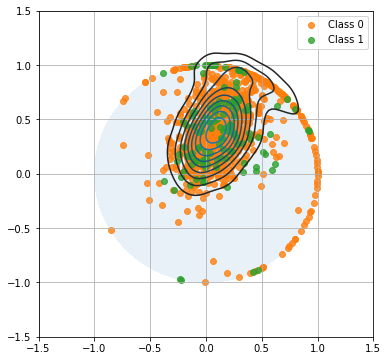

In [14]:
train_embeddings, train_labels = extract_embedding(train_loader, model, use_cuda)
fig, ax = plt.subplots(figsize=(6,6))
plot_2d_circle()
plot_2d_embedding(train_embeddings, 
                  train_labels, 
                  ax=ax, xlim=[-1.5, 1.5], 
                  ylim=[-1.5, 1.5])

## Train Model

In [ ]:
dict_train_loss = {}
list_end_epochs = [50, 500, 1000]
start_epoch = 0
for i, end_epoch in enumerate(list_end_epochs):
    tmp_dict_train_loss, _ = fit(online_train_loader, 
                                         None, 
                                         model, 
                                         loss_fn, 
                                         optimizer, None, 
                                         end_epoch, 
                                         use_cuda, 
                                         dict_args["log_interval"], 
                                         metrics=[AverageNonZeroTripletsMetric()],
                                         start_epoch=start_epoch)
    
    torch.save(model.state_dict(), "linear_triplet_norm_clamp_net_{}.pt".format(end_epoch))
    
    start_epoch = end_epoch
    
    dict_train_loss.update(tmp_dict_train_loss)

Epoch [1/50]: Avg. Train Loss: 0.66408 | Avg. Non-Zero Triplets: 41820.00000
Epoch [2/50]: Avg. Train Loss: 0.60678 | Avg. Non-Zero Triplets: 41819.00000
Epoch [3/50]: Avg. Train Loss: 0.57035 | Avg. Non-Zero Triplets: 41797.00000
Epoch [4/50]: Avg. Train Loss: 0.59739 | Avg. Non-Zero Triplets: 41819.00000
Epoch [5/50]: Avg. Train Loss: 0.54794 | Avg. Non-Zero Triplets: 41816.50000
Epoch [6/50]: Avg. Train Loss: 0.52010 | Avg. Non-Zero Triplets: 41797.00000
Epoch [7/50]: Avg. Train Loss: 0.52896 | Avg. Non-Zero Triplets: 41804.00000
Epoch [8/50]: Avg. Train Loss: 0.51793 | Avg. Non-Zero Triplets: 41819.00000
Epoch [9/50]: Avg. Train Loss: 0.53507 | Avg. Non-Zero Triplets: 41819.00000
Epoch [10/50]: Avg. Train Loss: 0.51341 | Avg. Non-Zero Triplets: 41819.00000
Epoch [11/50]: Avg. Train Loss: 0.55943 | Avg. Non-Zero Triplets: 41819.00000
Epoch [12/50]: Avg. Train Loss: 0.51130 | Avg. Non-Zero Triplets: 41819.00000
Epoch [13/50]: Avg. Train Loss: 0.45499 | Avg. Non-Zero Triplets: 41819.5

Epoch [106/500]: Avg. Train Loss: 0.61836 | Avg. Non-Zero Triplets: 9950.50000
Epoch [107/500]: Avg. Train Loss: 0.46486 | Avg. Non-Zero Triplets: 5477.00000
Epoch [108/500]: Avg. Train Loss: 0.54150 | Avg. Non-Zero Triplets: 10498.50000
Epoch [109/500]: Avg. Train Loss: 0.51739 | Avg. Non-Zero Triplets: 10555.00000
Epoch [110/500]: Avg. Train Loss: 0.36617 | Avg. Non-Zero Triplets: 21194.00000
Epoch [111/500]: Avg. Train Loss: 0.48435 | Avg. Non-Zero Triplets: 25970.50000
Epoch [112/500]: Avg. Train Loss: 0.18341 | Avg. Non-Zero Triplets: 8402.50000
Epoch [113/500]: Avg. Train Loss: 0.55215 | Avg. Non-Zero Triplets: 10913.00000
Epoch [114/500]: Avg. Train Loss: 0.37604 | Avg. Non-Zero Triplets: 10202.00000
Epoch [115/500]: Avg. Train Loss: 0.55078 | Avg. Non-Zero Triplets: 9728.50000
Epoch [116/500]: Avg. Train Loss: 0.54995 | Avg. Non-Zero Triplets: 9996.00000
Epoch [117/500]: Avg. Train Loss: 0.28207 | Avg. Non-Zero Triplets: 4946.50000
Epoch [118/500]: Avg. Train Loss: 0.42700 | Av

## Training Loss Plot

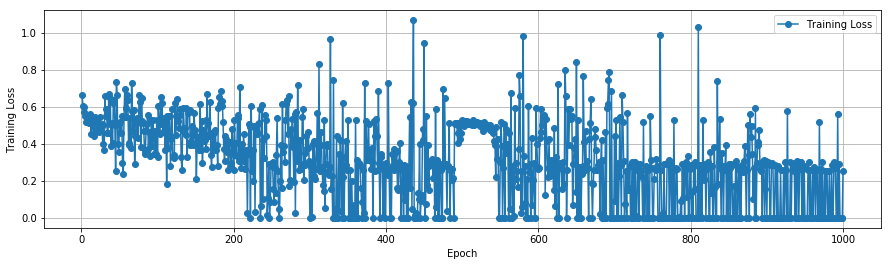

In [16]:
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(dict_train_loss.keys(), dict_train_loss.values(), marker="o", label="Training Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Loss")
ax.grid()
ax.legend();

## Trained Embeddings after 50 Epochs

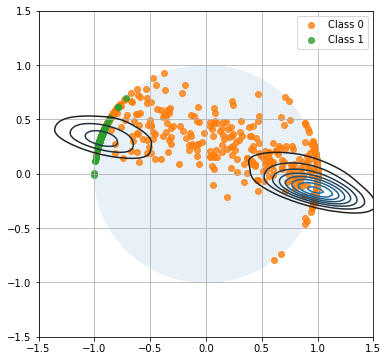

In [17]:
model = load_model("linear_triplet_norm_clamp_net_50.pt")

train_embeddings, train_labels = extract_embedding(train_loader, model, use_cuda)
fig, ax = plt.subplots(figsize=(6,6))
plot_2d_circle()
plot_2d_embedding(train_embeddings, 
                  train_labels, 
                  ax=ax, xlim=[-1.5, 1.5], 
                  ylim=[-1.5, 1.5])

## Trained Embeddings after 500 Epochs

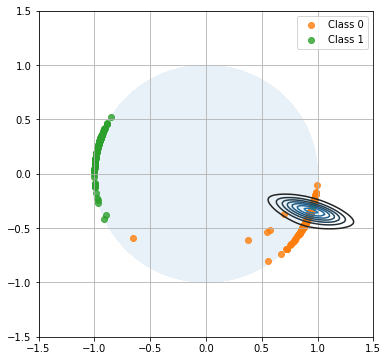

In [18]:
model = load_model("linear_triplet_norm_clamp_net_500.pt")

train_embeddings, train_labels = extract_embedding(train_loader, model, use_cuda)
fig, ax = plt.subplots(figsize=(6,6))
plot_2d_circle()
plot_2d_embedding(train_embeddings, 
                  train_labels, 
                  ax=ax, xlim=[-1.5, 1.5], 
                  ylim=[-1.5, 1.5])

## Trained Embeddings after 1000 Epochs

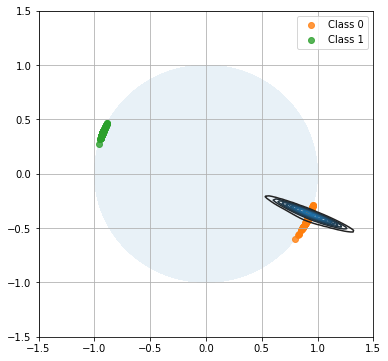

In [19]:
model = load_model("linear_triplet_norm_clamp_net_1000.pt")

train_embeddings, train_labels = extract_embedding(train_loader, model, use_cuda)
fig, ax = plt.subplots(figsize=(6,6))
plot_2d_circle()
plot_2d_embedding(train_embeddings, 
                  train_labels, 
                  ax=ax, xlim=[-1.5, 1.5], 
                  ylim=[-1.5, 1.5])